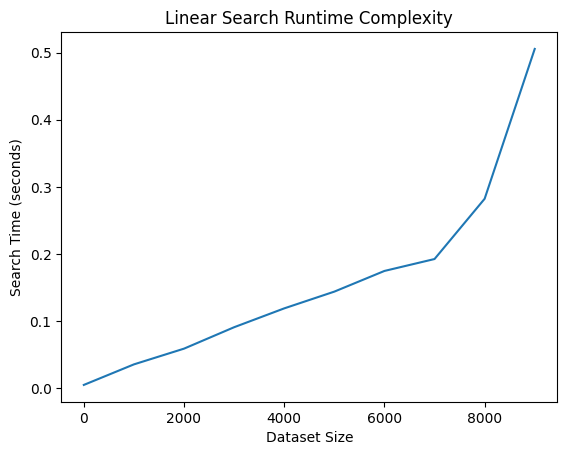

In [6]:
import time

def linear_search(dataset, username):
    for item in dataset:
        if item == username:
            return True
    return False

# Example of timing linear search
search_times = []
for i in range(1, num_usernames + 1, num_usernames // 10): # Varying dataset size
    subset = dataset[:i]
    start_time = time.time()
    for _ in range(10000):  # Perform 10,000 lookups
        linear_search(subset, generate_random_username())
    end_time = time.time()
    search_times.append(end_time - start_time)

# Plot the results
import matplotlib.pyplot as plt

plt.plot(range(1, num_usernames + 1, num_usernames // 10), search_times)
plt.xlabel("Dataset Size")
plt.ylabel("Search Time (seconds)")
plt.title("Linear Search Runtime Complexity")
plt.show()

In [57]:
import time
import random

def timing_decorator(func):
    """
    Decorator to measure the execution time of a function.
    """
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time  # Calculate elapsed time
        print(f"{func.__name__} took {elapsed_time:.4f} seconds")
        return elapsed_time  # Return the elapsed time
    return wrapper

def simple_hash(s, m):
    """
    A very basic hash function for demonstration.

    Args:
        s (str): The string to hash.
        m (int): The size of the hash table or bit array.

    Returns:
        int: The hash value (an index between 0 and m-1).
    """
    hash_val = 0
    for char in s:
        hash_val = (hash_val * 31 + ord(char)) % m  # Using a prime multiplier
    return hash_val

def mmh3_hash(s, m, seed=0):
    """
    A basic implementation of MurmurHash3 (32-bit version) for demonstration.

    Args:
        s (str): The string to hash.
        m (int): The size of the hash table or bit array.
        seed (int): Seed for the hash function

    Returns:
        int: The hash value (an index between 0 and m-1).
    """
    def fmix32(h):
        h ^= h >> 16
        h = (h * 0x85ebca6b) & 0xFFFFFFFF
        h ^= h >> 13
        h = (h * 0xc2b2ae35) & 0xFFFFFFFF
        h ^= h >> 16
        return h

    length = len(s)
    n_blocks = int(length / 4)

    h1 = seed

    c1 = 0xcc9e2d51
    c2 = 0x1b873593

    # body
    for block_start in range(0, n_blocks * 4, 4):
        # little endian
        k1 = ord(s[block_start + 3]) << 24 | \
            ord(s[block_start + 2]) << 16 | \
            ord(s[block_start + 1]) << 8 | \
            ord(s[block_start + 0])

        k1 = (c1 * k1) & 0xFFFFFFFF
        k1 = (k1 << 15 | k1 >> 17) & 0xFFFFFFFF  # inlined ROTL32
        k1 = (c2 * k1) & 0xFFFFFFFF

        h1 ^= k1
        h1 = (h1 << 13 | h1 >> 19) & 0xFFFFFFFF  # inlined ROTL32
        h1 = (h1 * 5 + 0xe6546b64) & 0xFFFFFFFF

    # tail
    tail_index = n_blocks * 4
    k1 = 0
    tail_size = length & 3

    if tail_size >= 3:
        k1 ^= ord(s[tail_index + 2]) << 16
    if tail_size >= 2:
        k1 ^= ord(s[tail_index + 1]) << 8
    if tail_size >= 1:
        k1 ^= ord(s[tail_index + 0])

    if tail_size > 0:
        k1 = (k1 * c1) & 0xFFFFFFFF
        k1 = (k1 << 15 | k1 >> 17) & 0xFFFFFFFF  # inlined ROTL32
        k1 = (k1 * c2) & 0xFFFFFFFF
        h1 ^= k1

    # finalization
    unsigned_val = fmix32(h1 ^ length)
    return unsigned_val % m

In [58]:
#from src.utils import simple_hash, mmh3_hash
import math
import random

class LoginChecker:
    def __init__(self, dataset=None, capacity=None, error_rate=0.001):
        """
        Initializes data structures for login checking algorithms.

        Args:
            dataset (list, optional): Pre-existing dataset of usernames. Defaults to None.
            capacity (int, optional): Estimated capacity for Bloom/Cuckoo filters. Defaults to None.
            error_rate (float, optional): Desired error rate for Bloom filter. Defaults to 0.001.
        """
        if dataset:
            self.dataset = dataset
            self.dataset_set = set(dataset)  # For hashing
            self.dataset.sort()  # For binary search

            # Bloom filter parameters
            self.capacity = len(dataset)
            self.error_rate = error_rate

            # Corrected the order here:
            self.bit_array_size = self._calculate_bit_array_size() # Calculate bit array size first
            self.num_hashes = self._calculate_num_hashes() # Then calculate the number of hashes

            self.bit_array = [0] * self.bit_array_size

            # Cuckoo filter parameters
            self.bucket_size = 4
            self.fingerprint_size = 2  # Adjust as needed
            self.max_displacements = 500 # Max kickout
            self.cuckoo_table = [([None] * self.bucket_size) for _ in range(self.capacity)]

            # Populate filters using the dataset
            for item in dataset:
                self._add_to_bloom_filter(item)
                self._insert_to_cuckoo_filter(item)
        else:
            self.dataset = []
            self.dataset_set = set()

            # Initialize filters with capacity and error_rate
            self.capacity = capacity
            self.error_rate = error_rate

            # Corrected the order here:
            self.bit_array_size = self._calculate_bit_array_size()
            self.num_hashes = self._calculate_num_hashes()

            self.bit_array = [0] * self.bit_array_size

            self.bucket_size = 4
            self.fingerprint_size = 2
            self.max_displacements = 500
            self.cuckoo_table = [([None] * self.bucket_size) for _ in range(self.capacity)]

    def linear_search(self, username):
        """
        Checks if a username exists using linear search.

        Args:
            username (str): The username to check.

        Returns:
            bool: True if the username exists, False otherwise.
        """
        for item in self.dataset:
            if item == username:
                return True
        return False

    def binary_search(self, username):
        """
        Checks if a username exists using binary search.

        Args:
            username (str): The username to check.

        Returns:
            bool: True if the username exists, False otherwise.
        """
        low = 0
        high = len(self.dataset) - 1
        while low <= high:
            mid = (low + high) // 2
            if self.dataset[mid] == username:
                return True
            elif self.dataset[mid] < username:
                low = mid + 1
            else:
                high = mid - 1
        return False

    def hash_search(self, username):
        """
        Checks if a username exists using a hash set.

        Args:
            username (str): The username to check.

        Returns:
            bool: True if the username exists, False otherwise.
        """
        return username in self.dataset_set

    def _calculate_bit_array_size(self):
        """
        Calculates the optimal size of the bit array for a Bloom filter.

        Returns:
            int: The size of the bit array.
        """
        m = - (self.capacity * math.log(self.error_rate)) / (math.log(2) ** 2)
        return int(m)

    def _calculate_num_hashes(self):
        """
        Calculates the optimal number of hash functions for a Bloom filter.

        Returns:
            int: The number of hash functions.
        """
        k = (self.bit_array_size / self.capacity) * math.log(2)
        return int(k)

    def _add_to_bloom_filter(self, username):
        """
        Adds a username to the Bloom filter.

        Args:
            username (str): The username to add.
        """
        for i in range(self.num_hashes):
            index = mmh3_hash(username, self.bit_array_size, seed=i)
            self.bit_array[index] = 1

    def bloom_filter_check(self, username):
        """
        Checks if a username might exist in the Bloom filter.

        Args:
            username (str): The username to check.

        Returns:
            bool: True if the username might exist, False if it definitely does not.
        """
        for i in range(self.num_hashes):
            index = mmh3_hash(username, self.bit_array_size, seed=i)
            if self.bit_array[index] == 0:
                return False
        return True

    def _get_fingerprint(self, item):
        """
        Generates a fingerprint for an item.

        Args:
            item (str): The item for which to generate a fingerprint.

        Returns:
            int: The fingerprint of the item.
        """
        hash_value = mmh3_hash(item, 2**(self.fingerprint_size * 8))
        return hash_value & ((1 << (self.fingerprint_size * 8)) - 1)

    def _insert_to_cuckoo_filter(self, item):
        """
        Inserts an item into the Cuckoo filter.

        Args:
            item (str): The item to insert.
        """
        f = self._get_fingerprint(item)
        i1 = simple_hash(item, self.capacity)
        i2 = (i1 ^ simple_hash(str(f), self.capacity)) % self.capacity

        for _ in range(self.max_displacements):
            for index in [i1, i2]:
                if 0 <= index < len(self.cuckoo_table):  # Check index bounds
                    for j in range(self.bucket_size):
                        if self.cuckoo_table[index][j] is None:
                            self.cuckoo_table[index][j] = f
                            return

            # If no empty slot, randomly kick out an item
            index = random.choice([i1, i2])
            if 0 <= index < len(self.cuckoo_table):  # Check index bounds
                j = random.randrange(self.bucket_size)
                f, self.cuckoo_table[index][j] = self.cuckoo_table[index][j], f
                i1 = index
                i2 = (i1 ^ simple_hash(str(f), self.capacity)) % self.capacity

        # If max displacements reached, filter is considered full
        raise Exception("Cuckoo filter is full")

    def cuckoo_filter_check(self, item):
        """
        Checks if an item might exist in the Cuckoo filter.

        Args:
            item (str): The item to check.

        Returns:
            bool: True if the item might exist, False if it definitely does not.
        """
        f = self._get_fingerprint(item)
        i1 = simple_hash(item, self.capacity)
        i2 = (i1 ^ simple_hash(str(f), self.capacity)) % self.capacity

        for index in [i1, i2]:
            if 0 <= index < len(self.cuckoo_table):  # Check index bounds
                for j in range(self.bucket_size):
                    if self.cuckoo_table[index][j] == f:
                        return True
        return False


In [59]:
import random
import string

def generate_random_username(length=8):
    """
    Generates a random username.

    Args:
        length (int): The length of the username.

    Returns:
        str: A random username.
    """
    characters = string.ascii_letters + string.digits
    return ''.join(random.choice(characters) for i in range(length))

def generate_dataset(num_usernames):
    """
    Generates a dataset of unique usernames.

    Args:
        num_usernames (int): The number of usernames to generate.

    Returns:
        list: A list of unique usernames.
    """
    usernames = set()
    while len(usernames) < num_usernames:
        usernames.add(generate_random_username())
    return list(usernames)

Running linear search with dataset size: 1000
run_experiment took 0.0157 seconds
Running linear search with dataset size: 5000
run_experiment took 0.0792 seconds
Running linear search with dataset size: 10000
run_experiment took 0.1602 seconds
Running linear search with dataset size: 50000
run_experiment took 1.4172 seconds
Running linear search with dataset size: 100000
run_experiment took 7.2301 seconds
Running binary search with dataset size: 1000
run_experiment took 0.0035 seconds
Running binary search with dataset size: 5000
run_experiment took 0.0041 seconds
Running binary search with dataset size: 10000
run_experiment took 0.0031 seconds
Running binary search with dataset size: 50000
run_experiment took 0.0054 seconds
Running binary search with dataset size: 100000
run_experiment took 0.0089 seconds
Running hash search with dataset size: 1000
run_experiment took 0.0007 seconds
Running hash search with dataset size: 5000
run_experiment took 0.0012 seconds
Running hash search with

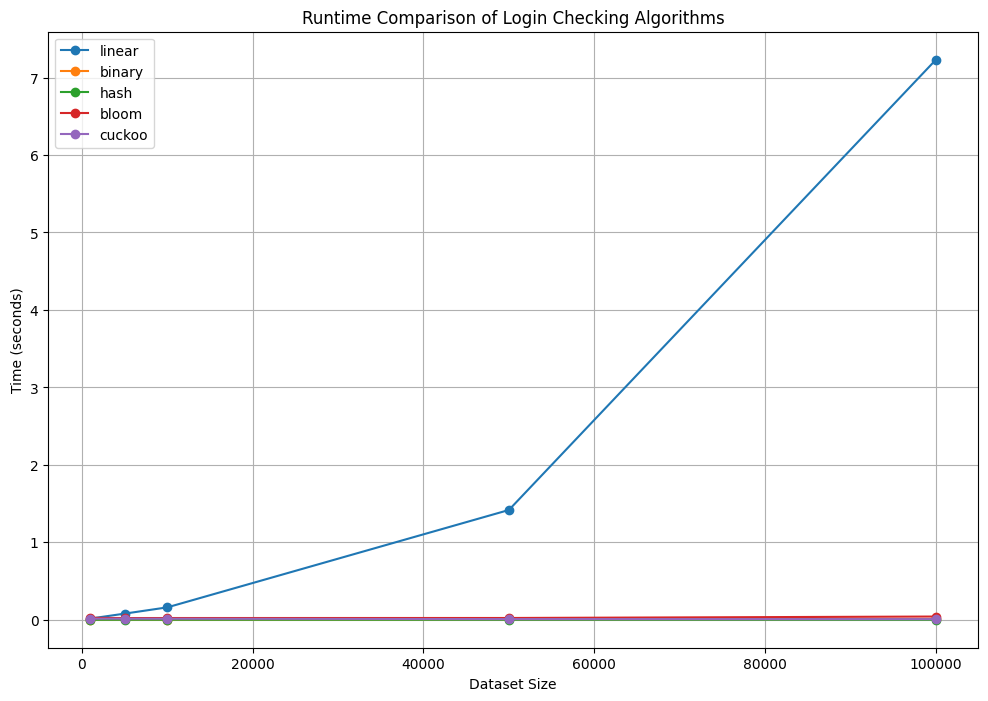

In [61]:
import matplotlib.pyplot as plt
# from src.dataset import generate_dataset
# from src.login_checker import LoginChecker
#from src.utils import timing_decorator
import random

@timing_decorator
def run_experiment(checker, dataset, num_lookups, search_type):
    """
    Runs a set of lookup experiments and times them.

    Args:
        checker (LoginChecker): An instance of the LoginChecker class.
        dataset (list): The dataset of usernames.
        num_lookups (int): The number of lookup operations to perform.
        search_type (str): The type of search to perform ('linear', 'binary', 'hash', 'bloom', 'cuckoo').
    """
    if search_type == "binary":
        dataset.sort()

    lookup_usernames = [random.choice(dataset) for _ in range(num_lookups)]
    lookup_usernames.extend([f"nonexistent_user_{i}" for i in range(num_lookups // 10)])

    if search_type == 'linear':
        for username in lookup_usernames:
            checker.linear_search(username)
    elif search_type == 'binary':
        for username in lookup_usernames:
            checker.binary_search(username)
    elif search_type == 'hash':
        for username in lookup_usernames:
            checker.hash_search(username)
    elif search_type == 'bloom':
        for username in lookup_usernames:
            checker.bloom_filter_check(username)
    elif search_type == 'cuckoo':
        for username in lookup_usernames:
            checker.cuckoo_filter_check(username)
    else:
        raise ValueError(f"Invalid search type: {search_type}")

def main():
    """
    Main function to run experiments and generate plots.
    """
    dataset_sizes = [1000, 5000, 10000, 50000, 100000]
    num_lookups = 1000
    search_types = ['linear', 'binary', 'hash', 'bloom', 'cuckoo']

    results = {}
    plt.figure(figsize=(12, 8))  # Create a larger figure for the combined plot

    for search_type in search_types:
        results[search_type] = []
        for size in dataset_sizes:
            print(f"Running {search_type} search with dataset size: {size}")
            dataset = generate_dataset(size)
            checker = LoginChecker(dataset=dataset, capacity=size, error_rate=0.01)
            elapsed_time = run_experiment(checker, dataset, num_lookups, search_type)
            results[search_type].append(elapsed_time)

        # Individual plot for each search type
        plt.figure(figsize=(8, 5))  # Create a separate figure for each algorithm
        plt.plot(dataset_sizes, results[search_type], label=search_type, marker='o')
        plt.xlabel("Dataset Size")
        plt.ylabel("Time (seconds)")
        plt.title(f"Runtime of {search_type.capitalize()} Search")
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{search_type}_runtime.png")  # Save individual plot
        plt.close()  # Close the individual plot figure

        # Add to the combined plot
        plt.plot(dataset_sizes, results[search_type], label=search_type, marker='o')

    # Combined plot
    plt.xlabel("Dataset Size")
    plt.ylabel("Time (seconds)")
    plt.title("Runtime Comparison of Login Checking Algorithms")
    plt.legend()
    plt.grid(True)
    plt.savefig("combined_runtime_comparison.png")  # Save the combined plot
    plt.show()  # Show the combined plot (optional)

if __name__ == "__main__":
    main()

In [70]:
import unittest
from unittest.mock import patch, MagicMock
import src.main as main  # Import the main module
import matplotlib.pyplot as plt

class TestMain(unittest.TestCase):
    @patch('src.main.generate_dataset')
    @patch('src.main.LoginChecker')
    @patch('src.main.run_experiment')
    def test_main_runs_experiments_and_generates_plots(self, mock_run_experiment, mock_login_checker, mock_generate_dataset):
        """
        Test that main() runs experiments for different dataset sizes and search types,
        and that it generates the plots correctly.
        """
        # Mock the dataset and LoginChecker
        mock_dataset = [1, 2, 3]
        mock_generate_dataset.return_value = mock_dataset
        mock_login_checker_instance = MagicMock()
        mock_login_checker.return_value = mock_login_checker_instance

        # Mock the run_experiment function to return a fixed time
        mock_run_experiment.return_value = 0.1

        # Call the main function (it will use the mocked objects)
        main.main()

        # Assert that generate_dataset was called with the correct dataset sizes
        expected_dataset_sizes = [1000, 5000, 10000, 50000, 100000]
        for size in expected_dataset_sizes:
            mock_generate_dataset.assert_any_call(size)

        # Assert that LoginChecker was called with the correct arguments
        for size in expected_dataset_sizes:
            mock_login_checker.assert_any_call(dataset=mock_dataset, capacity=size, error_rate=0.01)

        # Assert that run_experiment was called the correct number of times
        expected_search_types = ['linear', 'binary', 'hash', 'bloom', 'cuckoo']
        self.assertEqual(mock_run_experiment.call_count, len(expected_dataset_sizes) * len(expected_search_types))

        # Assert that run_experiment was called with the correct arguments
        for search_type in expected_search_types:
            for size in expected_dataset_sizes:
                mock_run_experiment.assert_any_call(mock_login_checker_instance, mock_dataset, 1000, search_type)

    @patch('src.main.plt')
    def test_main_generates_plots(self, mock_plt):
        """
        Test that main() generates the plots correctly (using mocking).
        """
        # Configure mock dataset and results (replace with your actual expected data)
        mock_dataset_sizes = [1000, 5000]
        mock_results = {
            'linear': [0.1, 0.2],
            'binary': [0.01, 0.02],
            'hash': [0.001, 0.002],
            'bloom': [0.005, 0.006],
            'cuckoo': [0.002, 0.003],
        }

        # Mock the necessary functions to return the configured data
        with patch('src.main.generate_dataset', return_value=[]), \
             patch('src.main.LoginChecker', return_value=MagicMock()), \
             patch('src.main.run_experiment', side_effect=[0.1, 0.2, 0.01, 0.02, 0.001, 0.002, 0.005, 0.006, 0.002, 0.003]):

            # Run the main function
            main.main()

            # Assert that the plot functions were called correctly
            self.assertEqual(mock_plt.figure.call_count, 6)  # 1 combined plot + 5 individual plots
            self.assertEqual(mock_plt.plot.call_count, 10)  # 5 individual plots + 5 lines on combined plot
            self.assertEqual(mock_plt.xlabel.call_count, 6)
            self.assertEqual(mock_plt.ylabel.call_count, 6)
            self.assertEqual(mock_plt.title.call_count, 6)
            self.assertEqual(mock_plt.legend.call_count, 6)
            self.assertEqual(mock_plt.grid.call_count, 6)
            self.assertEqual(mock_plt.savefig.call_count, 6)  # 5 individual + 1 combined
            self.assertEqual(mock_plt.close.call_count, 5)  # Close individual plots
            mock_plt.show.assert_called_once()

            # Assert that savefig was called with the correct filenames
            mock_plt.savefig.assert_any_call("linear_runtime.png")
            mock_plt.savefig.assert_any_call("binary_runtime.png")
            mock_plt.savefig.assert_any_call("hash_runtime.png")
            mock_plt.savefig.assert_any_call("bloom_runtime.png")
            mock_plt.savefig.assert_any_call("cuckoo_runtime.png")
            mock_plt.savefig.assert_any_call("combined_runtime_comparison.png")

if __name__ == '__main__':
    unittest.main()

E
ERROR: /root/ (unittest.loader._FailedTest./root/)
----------------------------------------------------------------------
AttributeError: module '__main__' has no attribute '/root/'

----------------------------------------------------------------------
Ran 1 test in 0.002s

FAILED (errors=1)


SystemExit: True

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
